# Super resolotion with GAN

In this notebook, we will scratch the surface with `GAN` and `UNET` by tackling the problem of **Super Resolution**.

In [0]:
  #!curl -s https://course.fast.ai/setup/colab | bash
  !pwd

/content


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
from fastai.vision import *
from fastai.vision.gan import *
from fastai.callbacks import *
import fastai

## Preparing the pets data

In [0]:
path = untar_data(URLs.PETS)
path_hr = path/'images'     #path for high resolution images
path_lr = path/'crappy'     #crappified data

### Crappifying the data

Let's crappify our data to get some dirty images. The final goal is to restore the initial images at their best resolution

In [0]:
from crappify import *

now we will create our crappified version of each image. this process is time and ressource consuming. So do it just once and comment the following lines

In [0]:
il = ImageList.from_folder(path_hr)
parallel(crappifier(path_lr,path_hr), il.items)

We choose a target size and batch size accoring to hour graphical card ressources

In [0]:
bs,size=32, 128
# bs,size = 24,160
#bs,size = 8,256


## Pretrained Generator

In [0]:
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)
arch = models.resnet34

In [0]:
def get_data(bs,size):
    """
    Function to create a data bunch from the src according to the choosed bs and size
    """
    data = (src.label_from_func(lambda x: path_hr/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

In [0]:
data_gen = get_data(bs,size)

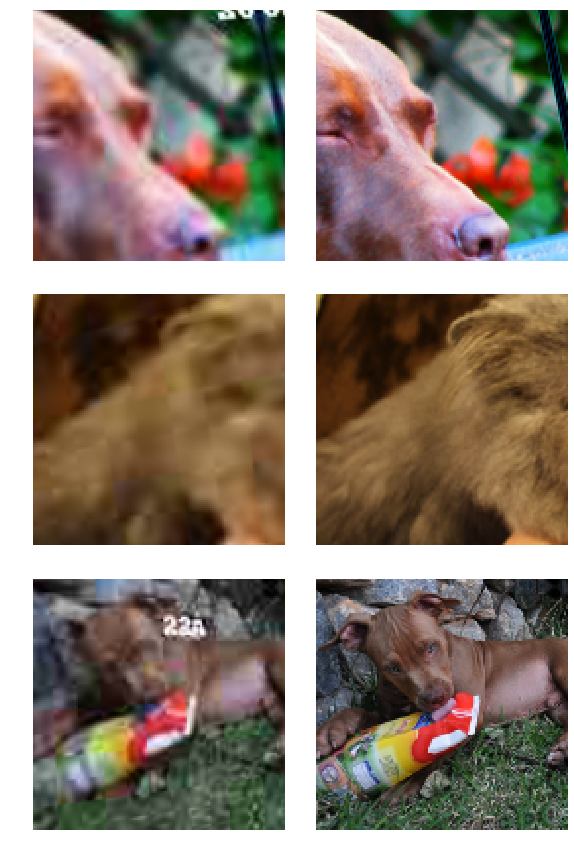

In [0]:
data_gen.show_batch(3)

### Generating learner

In [0]:
wd = 1e-3      #weight decay
y_range = (-3. ,3.)
loss_gen = MSELossFlat()          # loss function of the generator as Mean Square Error

In [0]:
# We should explain the (norm_type and sel_attention in future notebooks)
def create_gen_learner():
    return unet_learner(data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight,
                         self_attention=True, y_range=y_range, loss_func=loss_gen)


Now let's create and train a generator, which from a crappy images $M_{low}$ tries to create a high resolution image $M_{high}$. As stated the generator loss is the simple `MSE`

In [0]:
learn_gen = create_gen_learner()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 164167870.39it/s]


In [0]:
learn_gen.fit_one_cycle(2, pct_start=0.8)

In [0]:
learn_gen.unfreeze()

In [0]:
learn_gen.fit_one_cycle(1, slice(1e-6,1e-3))

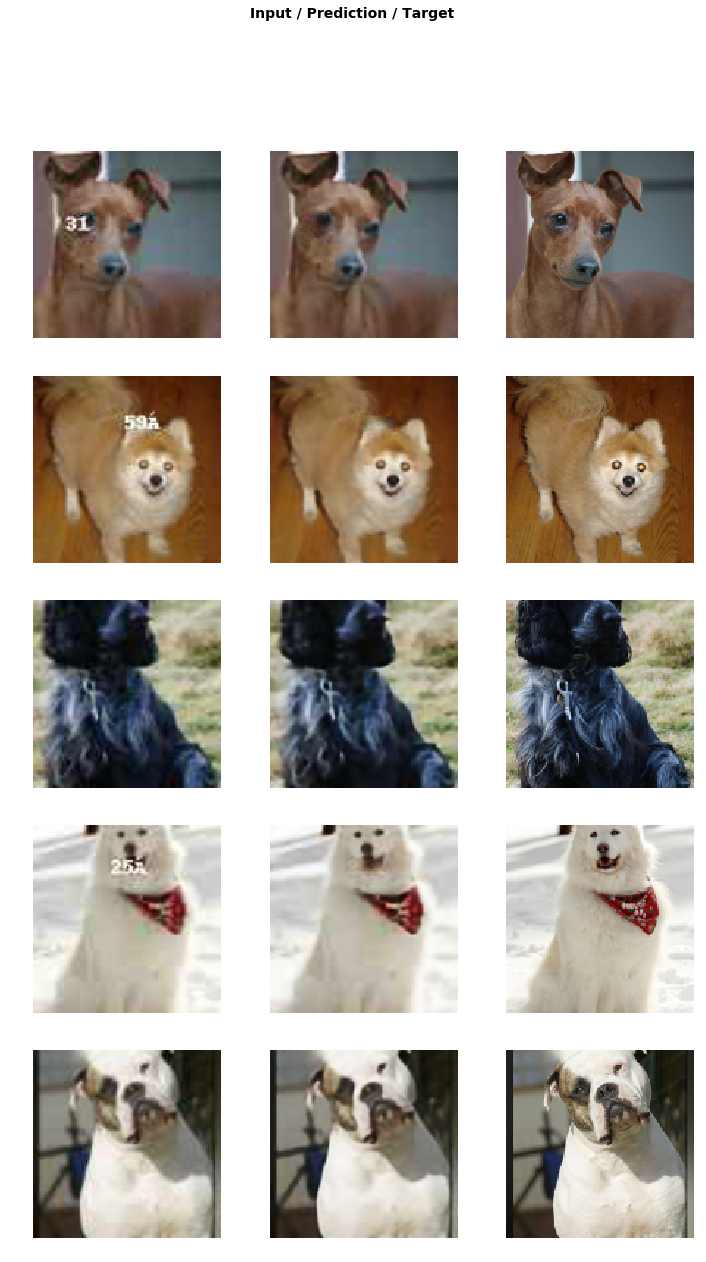

In [0]:
learn_gen.show_results()

In [0]:
#let save our models in the google colab for future sessions
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Let's save the current state of our model

In [0]:
gen_model_file = learn_gen.save('gen_pre2',return_path=True)

In [0]:
#print(gen_model_file)
#shutil.copy(gen_model_file,'/content/drive/My Drive/colab')


'/root/.fastai/data/oxford-iiit-pet/crappy/models/gen_pre2.pth'

## Save the generated images

In [0]:
shutil.copy('/content/drive/My Drive/colab/gen_pre2.pth', '/root/.fastai/data/oxford-iiit-pet/crappy/models/gen_pre2.pth')
learn_gen.load('gen_pre2')

Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/crappy;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /root/.fastai/data/oxford-iiit-pet/crappy;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, 

In [0]:
#path of the generated images
name_gen = 'image_gen'
path_gen = path/name_gen

In [0]:
path_gen.mkdir(exist_ok=True) #creating the image ( the flag exist_ok )

Let's write a function to save the reconstructed images by a the generator. Those images will serve as input to our **critic** (Descriminator)

In [0]:
def save_preds(dl):   #dataloader
    i = 0
    #getting the names in the datalist
    names = dl.dataset.items
    
    #looping over the batches
    for b in dl:
        #computing the predictions
        preds = learn_gen.pred_batch(batch=b, reconstruct=True) #reconstruct to creat a real Image List
        #loop to save the images in preds
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1

In [0]:
save_preds(data_gen.fix_dl)

Let's show a simple saved image from the generator

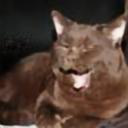

In [0]:
PIL.Image.open(path_gen.ls()[0])

## Training the descriminator

In [0]:
#collect garbage ( poor solution)
learn_gen=None
gc.collect()

7

Let's define a descriminator to differentiate images from crappy and not crappy

In [0]:
#Function to load the images since it will change after each iteration between the genrator and descriminator
def get_crit_data(classes, bs, size):
    src = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    ll = src.label_from_folder(classes=classes)
    data = (ll.transform(get_transforms(max_zoom=2.), size=size)
           .databunch(bs=bs).normalize(imagenet_stats))
    data.c = 3
    return data

In [0]:
data_crit = get_crit_data([name_gen, 'images'], bs=bs, size=size)

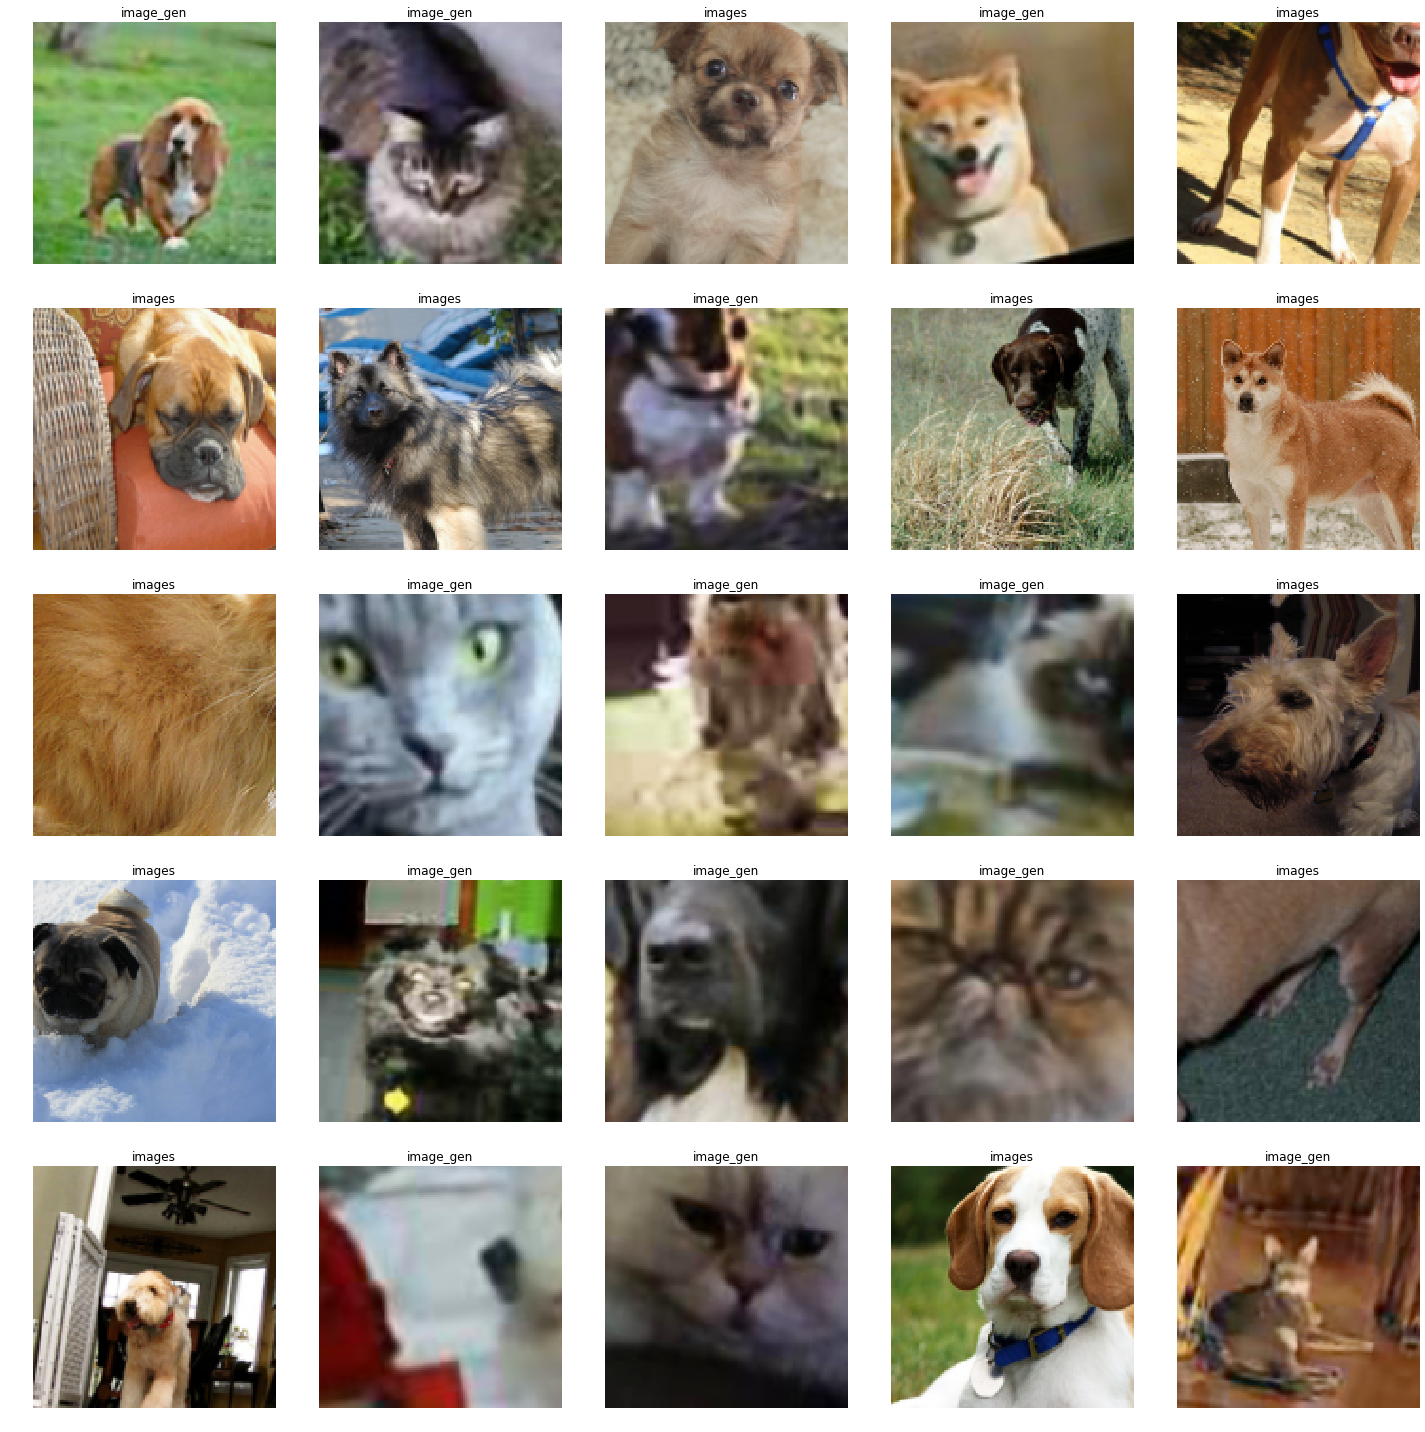

In [0]:
data_crit.show_batch()

Custom loss for the descriminator

In [0]:
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

In [0]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

In [0]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

In [0]:
learn_critic.fit_one_cycle(6, 1e-3)

In [0]:
#saving the critic weights
base_drive = Path('/content/drive/My Drive/colab')
path_critic= learn_critic.save('critic-pre2',return_path=True)
shutil.copy(path_critic, base_drive/'critic-pre2.pth')

PosixPath('/content/drive/My Drive/colab/critic-pre2.pth')

#Generative Adversalian Networks

Now that we have at our dispol, a pretrained `generator` and `Descriminator`. We can train our generative model. The loss of the generator is combination of the **MSE** and **Descriminator loss**

In [0]:
#collect garbage memory
learn_crit=None
learn_gen=None
gc.collect()


49113

In [0]:
# Function to generate the descriminator data
data_crit = get_crit_data(['crappy', 'images'], bs=bs, size=size)

In [0]:
#create a descriminator
shutil.copy(base_drive/'critic-pre2.pth', '/root/.fastai/data/oxford-iiit-pet/models/critic-pre2.pth')
learn_crit = create_critic_learner(data_crit, metrics=None).load('critic-pre2')

In [0]:
#create a generator
shutil.copyfile('/content/drive/My Drive/colab/gen-pre2.pth', '/root/.fastai/data/oxford-iiit-pet/crappy/models/gen-pre2.pth')
learn_gen = create_gen_learner().load('gen-pre2')

In order to create a **GAN**  we specify a `gen` learner and a `critic` learner. . The **switcher** is a callback that decides when to switch from discriminator to generator and vice versa. Here we do as many iterations of the discriminator as needed to get its loss **back < 0.5** then **one iteration** of the generator.

The loss of the critic is given by `learn_crit.loss_func`. We take the average of this loss function on the batch of real predictions ($target= 1$) and the batch of fake predicitions ($target= 0$).

The loss of the generator is weighted sum (**weights in weights_gen**) of `learn_crit.loss_func` on the batch of fake (passed throught the critic to become predictions) with a target of 1, and the learn_gen.loss_func applied to the output (batch of fake) and the target (corresponding batch of superres images).

In [0]:
# We switch the training phase when the critic loss become superior than a threshold 0.65
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_crit, weights_gen=(1.,50.), show_img=True, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.99)), wd=wd)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))

In [0]:
lr = 1e-4

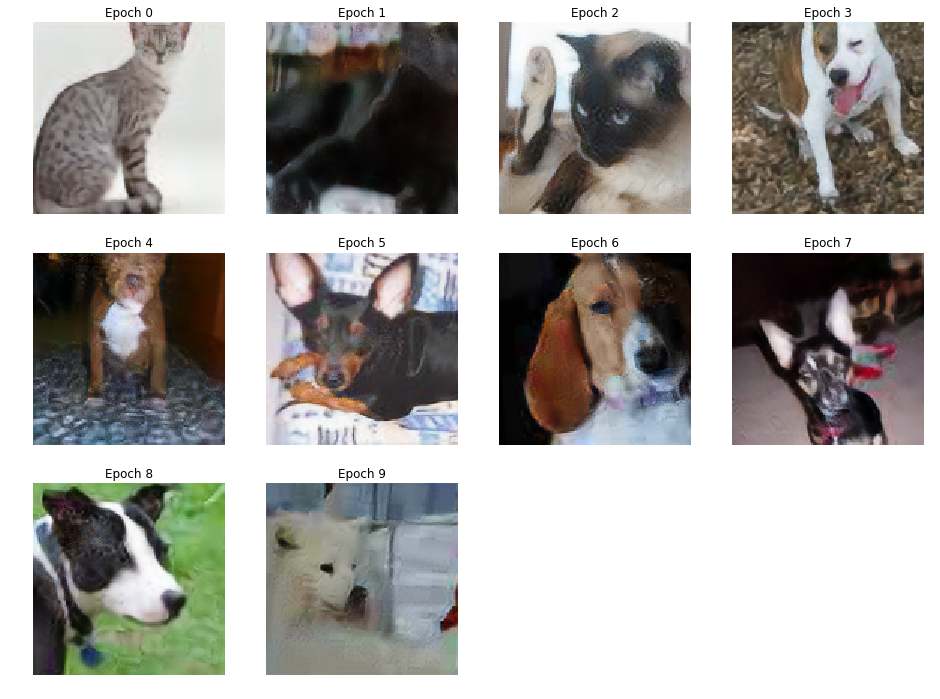

In [0]:
learn.fit(10,lr)

In [0]:
path_learn = learn.save('gan-1c',return_path=True)
print(path_learn)
shutil.copy(path_learn,'/content/drive/My Drive/colab/gan-1c.pth')

/root/.fastai/data/oxford-iiit-pet/crappy/models/gan-1c.pth


'/content/drive/My Drive/colab/gan-1c.pth'

### Training on higher image size

In [0]:
learn.data=get_data(16,192)

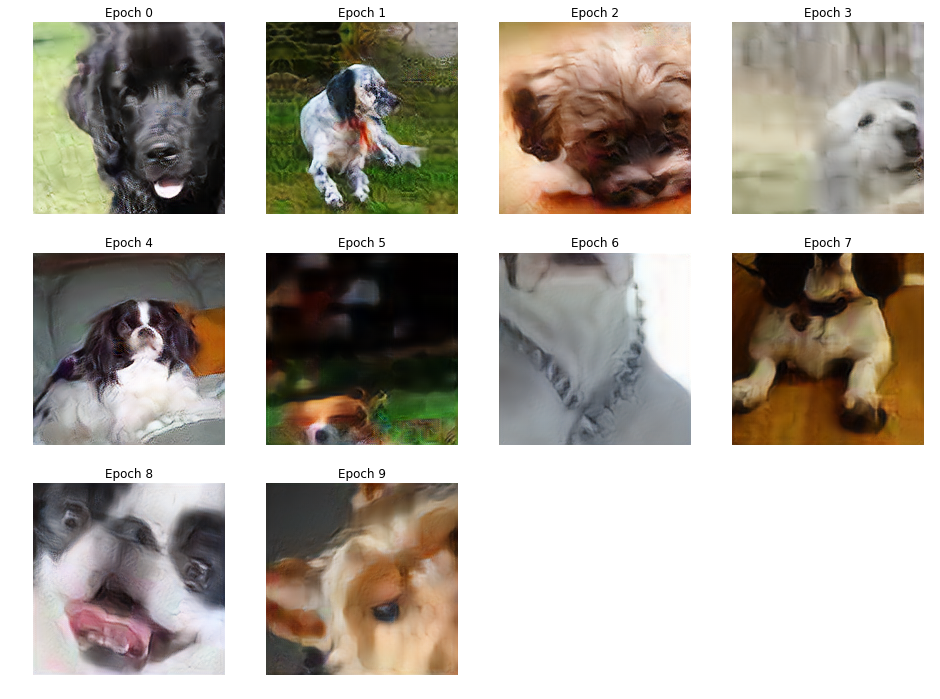

In [101]:
learn.fit(10,lr/2)

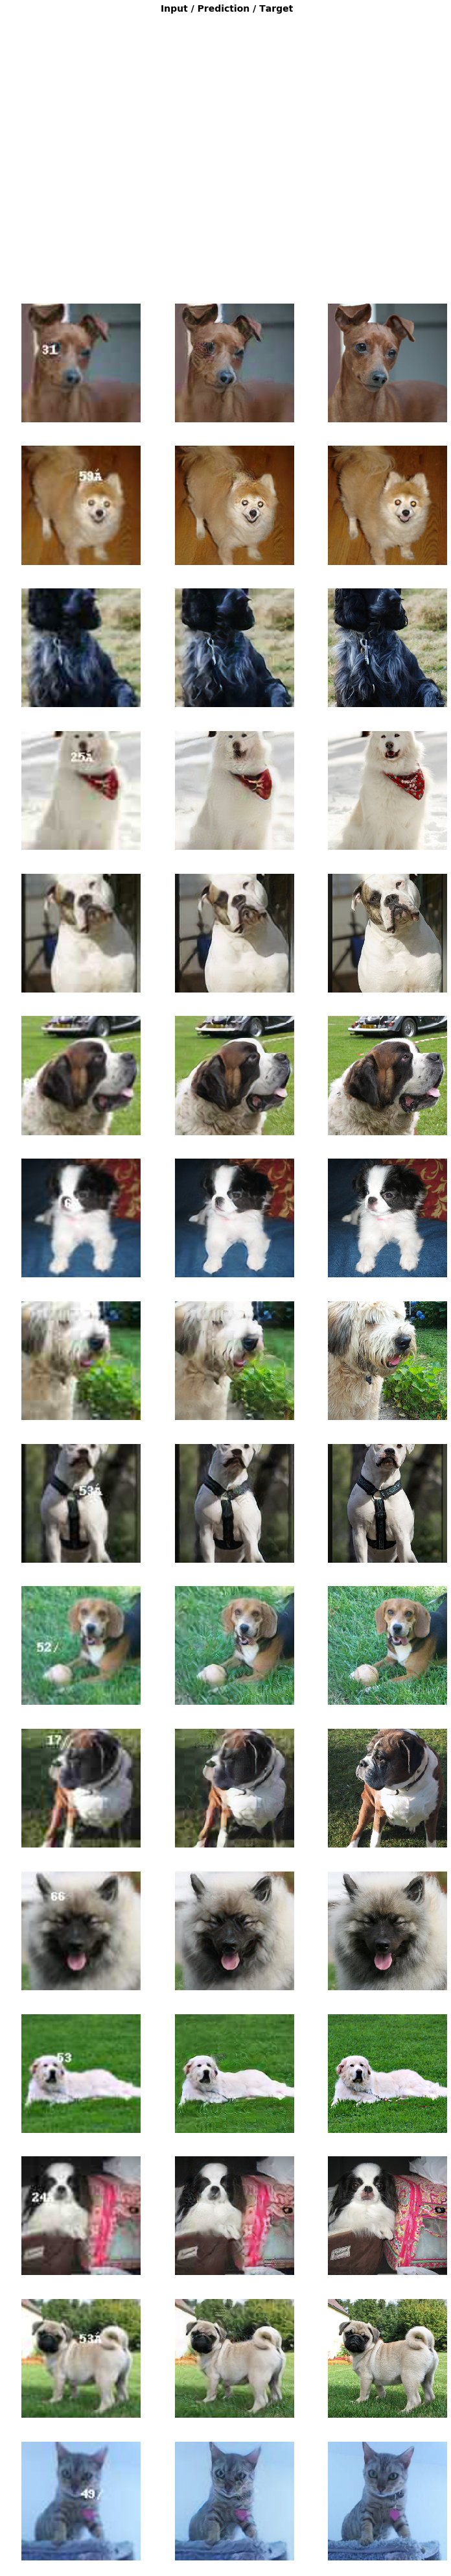

In [102]:
learn.show_results(rows=16)

In [103]:
path_learn = learn.save('gan-1d',return_path=True)
shutil.copy(path_learn,'/content/drive/My Drive/colab/gan-1d.pth')

'/content/drive/My Drive/colab/gan-1d.pth'